# Santa Catarina TFA inversion

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando import utils
from fatiando.vis import mpl
from fatiando.gravmag import polyprism

### Auxiliary functions

In [27]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing TFA data

In [34]:
data = pd.read_csv('anitapolis_decimated_amf_cut.txt', skipinitialspace=True, delim_whitespace=True)

In [35]:
data['z'] = data['z'] + 800

In [36]:
mask = (data['y'] <= 693000) & (data['y'] >= 683000.) & (data['x'] <= 6926000.) & (data['x'] >= 6916000.) & (data['z'].get_values()<0.)
data = data[mask]

In [37]:
xp = data['x'].get_values()
yp = data['y'].get_values()
zp = data['z'].get_values()
dobs = data['amf'].get_values()

In [38]:
zp

array([-293.1 , -282.71, -271.11, ..., -335.43, -335.79, -337.13])

### Parameters for inversion

In [39]:
# output of inversion
inversion = dict()

In [40]:
inversion['xp'] = xp
inversion['yp'] = yp
inversion['zp'] = zp
inversion['observed_data'] = dobs
N = xp.size

In [41]:
#initial estimate
M = 20 # number of vertices per prism
L = 6 # number of prismsinc-37_dec-18_r1000_int6_z0250_dz300/
P = L*(M+2) + 1 # number of parameters

#figura
incs = -21
decs = -11
intensity = 14
z0 = 0.
dz = 900.
r = 700.
x0 = 6921000.
y0 = 688000.

# main field
inc = -37.05
dec = -18.17

model0, m0 = mfun.initial_cylinder(M, L, x0,
        y0, z0, dz, r, inc, dec, incs, decs, intensity)

# predict data
d0 = np.sqrt(polyprism.bx(xp, yp, zp, model0)**2.+
            polyprism.by(xp, yp, zp, model0)**2.+
            polyprism.bz(xp, yp, zp, model0)**2.)

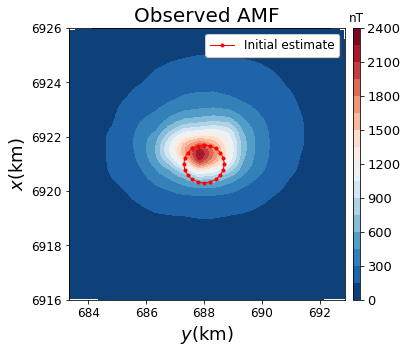

In [42]:
plt.figure(figsize=(6,5))
plt.title('Observed AMF', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

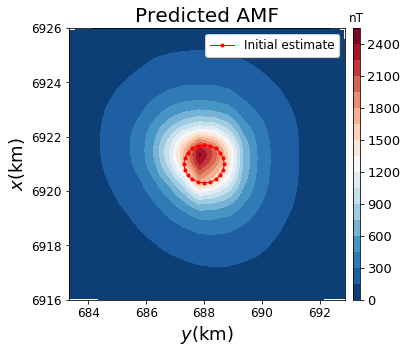

In [43]:
plt.figure(figsize=(6,5))
plt.title('Predicted AMF', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

In [44]:
# limits for parameters in meters
rmin = 100.
rmax = 3000.
y0min = 684000.
y0max = 695000.
x0min = 6918000.
x0max = 6926000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

In [45]:
# variation for derivatives
deltax = 0.01*np.max(1000.)
deltay = 0.01*np.max(1000.)
deltar = 0.01*np.max(1000.)
deltaz = 0.01*np.max(1000.)
delta = np.array([deltax, deltay, deltar, deltaz])

In [46]:
m_out = np.zeros(M + 2)  # outcropping body parameters

### Regularization parameters

In [47]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-3  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-3     # vertically adjacent origins
a6 = 1.0e-6   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [48]:
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [49]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

### Inversion

In [50]:
d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_amf(xp, yp, zp, m0, M, L, delta, itmax,
                                                    itmax_marq, lamb, dlamb, tol,
                                                    mmin, mmax, m_out, dobs,
                                                    model0[0].props, alpha, z0, dz)

it:  0   it_marq:  0   lambda: 1e+01   init obj.: 1.99874e+04  fin obj.: 1.02211e+04
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 1.02211e+04  fin obj.: 5.10510e+03
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 5.10510e+03  fin obj.: 7.65664e+03
it:  2   it_marq:  1   lambda: 1e+00   init obj.: 5.10510e+03  fin obj.: 2.74958e+03
it:  3   it_marq:  0   lambda: 1e-01   init obj.: 2.74958e+03  fin obj.: 4.85662e+03
it:  3   it_marq:  1   lambda: 1e+00   init obj.: 2.74958e+03  fin obj.: 1.90258e+03
it:  4   it_marq:  0   lambda: 1e-01   init obj.: 1.90258e+03  fin obj.: 6.03609e+03
it:  4   it_marq:  1   lambda: 1e+00   init obj.: 1.90258e+03  fin obj.: 1.53440e+03
it:  5   it_marq:  0   lambda: 1e-01   init obj.: 1.53440e+03  fin obj.: 9.23745e+03
it:  5   it_marq:  1   lambda: 1e+00   init obj.: 1.53440e+03  fin obj.: 1.41446e+03
it:  6   it_marq:  0   lambda: 1e-01   init obj.: 1.41446e+03  fin obj.: 6.93033e+03
it:  6   it_marq:  1   lambda: 1e+00   init obj.: 1.41446e+03  fi

In [18]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['initial_estimate'] = model0
inversion['initial_data'] = d0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = alpha
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]

In [19]:
mypath = 'amf_inversion/V%d_L%d_inc%d_dec%d_r%d_int%d_z0%d_dz%d' % (M, L, incs, decs, r, intensity, z0, dz)
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [20]:
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit

In [21]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [22]:
mypath

'amf_inversion/V30_L8_inc-37_dec-18_r1500_int3_z0-1200_dz700'